In [14]:
from pathlib import Path
from Bio.PDB import PDBList, PDBParser
import os
from tqdm import tqdm
import warnings
import pandas as pd
from Bio import SeqIO
from dotenv import load_dotenv
import os
import requests
import time
import json
from Bio.PDB.ic_rebuild import structure_rebuild_test
import numpy as np
import sys
import seaborn as sns
from Bio.Align import PairwiseAligner
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.patches as mpatches
load_dotenv()
amino_acid_codes = json.load(open('amino_acid_codes.json'))

In [81]:
WINDOW_SIZE = 5
WINDOW_SIZE_CONTEXT = 6
PDBMINE_URL = os.getenv("PDBMINE_URL")
casp_protein_id = 'T1030'
casp_protein_id2 = 'T1030'
pdb_code = '6poo'
# casp_protein_id = 'T1024'
# casp_protein_id2 = 'T1024'
# pdb_code = '6t1z'
alphafold_id = f'{casp_protein_id}TS427_1'
outdir = Path(f'tests/{casp_protein_id}_win{WINDOW_SIZE}-{WINDOW_SIZE_CONTEXT}')
if outdir.exists():
    print('Results already exist')
else:
    outdir.mkdir(exist_ok=False, parents=True)

Results already exist


In [3]:
def get_center(seq):
    if WINDOW_SIZE % 2 == 0:
        return seq[WINDOW_SIZE // 2 - 1]
    else:
        return seq[-WINDOW_SIZE // 2]
def get_seq(i):
    if WINDOW_SIZE % 2 == 0:
        if WINDOW_SIZE_CONTEXT % 2 == 0:
            return slice(i-WINDOW_SIZE//2+1,i+WINDOW_SIZE//2+1)
        return slice(i-WINDOW_SIZE//2,i+WINDOW_SIZE//2)
    else:
        return slice(i-WINDOW_SIZE//2,i+WINDOW_SIZE//2+1)
def get_seq_ctxt(i):
    if WINDOW_SIZE_CONTEXT % 2 == 0:
        return slice(i-WINDOW_SIZE_CONTEXT//2+1,i+WINDOW_SIZE_CONTEXT//2+1)
    return slice(i-WINDOW_SIZE_CONTEXT//2,i+WINDOW_SIZE_CONTEXT//2+1)
def get_subseq(seq):
    if WINDOW_SIZE % 2 == 0:
        return seq[WINDOW_SIZE_CONTEXT//2 - WINDOW_SIZE//2:WINDOW_SIZE_CONTEXT//2 + WINDOW_SIZE//2]
    else:
        if WINDOW_SIZE_CONTEXT % 2 == 0:
            return seq[WINDOW_SIZE_CONTEXT//2 - WINDOW_SIZE//2-1:WINDOW_SIZE_CONTEXT//2 + WINDOW_SIZE//2]
        return seq[WINDOW_SIZE_CONTEXT//2 - WINDOW_SIZE//2:WINDOW_SIZE_CONTEXT//2 + WINDOW_SIZE//2 + 1]

In [4]:
# Get X-ray pdb
pdbl = PDBList()
parser = PDBParser()
xray_fn = pdbl.retrieve_pdb_file(pdb_code, pdir='pdb', file_format='pdb', obsolete=False)

# Get CASP predictions
predictions_url = f'https://predictioncenter.org/download_area/CASP14/predictions/regular/{casp_protein_id}.tar.gz'
predictions_dir = Path(f'./casp-predictions/')
if not (predictions_dir / casp_protein_id).exists():
    predictions_dir.mkdir(exist_ok=True)
    os.system(f'wget -O {predictions_dir}/{casp_protein_id}.tar.gz {predictions_url}')
    os.system(f'tar -xvf {predictions_dir}/{casp_protein_id}.tar.gz -C {predictions_dir}')

# Get CASP results
results_url = 'https://predictioncenter.org/download_area/CASP14/results/tables/casp14.res_tables.T.tar.gz'
results_dir = Path('casp-results')
if not results_dir.exists():
    results_dir.mkdir(exist_ok=True)
    os.system(f'wget -O {results_dir / "casp14.res_tables.T.tar.gz"} {results_url}')
    os.system(f'tar -xvf {results_dir / "casp14.res_tables.T.tar.gz"} -C {results_dir}')
results_file = results_dir / f'{casp_protein_id2}.txt'
results = pd.read_csv(results_file, delim_whitespace=True)
results = results[results.columns[1:]]
results['Model'] = results['Model'].apply(lambda x: x.split('-')[0])

Structure exists: 'pdb/pdb6poo.ent' 


/tmp/ipykernel_3173062/2842285514.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  results = pd.read_csv(results_file, delim_whitespace=True)


In [5]:
# Check alignment of casp prediction and x-ray structure
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    record = next(iter(SeqIO.parse(xray_fn, "pdb-seqres")))
    print("Record id %s, chain %s" % (record.id, record.annotations["chain"]))
    # print(record.seq)
    print(len(record.seq))
    residue_chain = str(record.seq)#[residue_range[0]-1:residue_range[1]]
    print(residue_chain)

    pred_files = list((predictions_dir / casp_protein_id).iterdir())
    i=0
    print(pred_files[i].name)
    pred_seq = str(next(iter(SeqIO.parse(pred_files[i], "pdb-atom"))).seq)
    print(pred_seq)

    aligner = PairwiseAligner()
    aligner.mode = 'global'
    alignments =  aligner.align(residue_chain, pred_seq)

    print(alignments[0])
    print('Large matches:')
    for i,((t1,t2),(q1,q2)) in enumerate(zip(*alignments[0].aligned)):
        if t2-t1 > 5:
            print(f'Match of length: {t2-t1} residues at position t={t1}, q={q1}')

Record id 6POO:A, chain A
273
DQELGKQSRRSQDIIKSLGFLSSDQKDILVKSISSSKDSQLILKFVTQATQLNNAESTKAKQMAQNDVALIKNISPEVLEEYKEKIQRASTKSQVDEFVAEAKKVVNSNKETLVNQANGKKQEIAKLENLSNDEMLRYNTAIDNVVKQYNEGKLNITAAMNALNSIKQAAQEVAQKNLQKQYAKKIERISSKGLALSKKAKEIYEKHKSILPTPGYYADSVGTYLNRFRDKQTFGNRSVWTGQSGLDEAKKMLDEVKKLLKELQDLTRGTKED
T1030TS392_3
DQELGKQSRRSQDIIKSLGFLSSDQKDILVKSISSSKDSQLILKFVTQATQLNNAESTKAKQMAQNDVALIKNISPEVLEEYKEKIQRASTKSQVDEFVAEAKKVVNSNKETLVNQANGKKQEIAKLENLSNDEMLRYNTAIDNVVKQYNEGKLNITAAMNALNSIKQAAQEVAQKNLQKQYAKKIERISSKGLALSKKAKEIYEKHKSILPTPGYYADSVGTYLNRFRDKQTFGNRSVWTGQSGLDEAKKMLDEVKKLLKELQDLTRGTKED
target            0 DQELGKQSRRSQDIIKSLGFLSSDQKDILVKSISSSKDSQLILKFVTQATQLNNAESTKA
                  0 ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
query             0 DQELGKQSRRSQDIIKSLGFLSSDQKDILVKSISSSKDSQLILKFVTQATQLNNAESTKA

target           60 KQMAQNDVALIKNISPEVLEEYKEKIQRASTKSQVDEFVAEAKKVVNSNKETLVNQANGK
                 60 ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
que

# Collect Dihedrals - Xray and predictions

In [508]:
xray_structure = parser.get_structure(pdb_code, xray_fn)
xray_chain = list(xray_structure[0].get_chains())[0]

def get_phi_psi_for_structure(protein_structure, protein_id):
    protein_structure.atom_to_internal_coordinates(verbose=False)
    resultDict = structure_rebuild_test(protein_structure)
    if not resultDict['pass']:
        raise Exception('Failed to rebuild')
    residues = list(protein_structure.get_residues())
    phi_psi_ = []
    for i in range(WINDOW_SIZE_CONTEXT//2, len(residues) - WINDOW_SIZE_CONTEXT // 2):
        # Convert 3 char codes to 1 char codes
        seq = ''.join([amino_acid_codes.get(r.resname, 'X') for r in residues[get_seq(i)]])
        seq_ctxt = ''.join([amino_acid_codes.get(r.resname, 'X') for r in residues[get_seq_ctxt(i)]])
        # Get the center residue
        res = get_center(seq)
        if not residues[i].internal_coord:
            psi,phi = np.nan, np.nan
        else:
            psi = residues[i].internal_coord.get_angle("psi")
            phi = residues[i].internal_coord.get_angle("phi")
            psi = psi if psi else np.nan # if psi is None, set it to np.nan
            phi = phi if phi else np.nan # if phi is None, set it to np.nan
        phi_psi_.append([i, seq, seq_ctxt, res, phi, psi, xray_chain.id, protein_id])
    return phi_psi_

if not (outdir / 'xray_phi_psi.csv').exists():
    xray_phi_psi = get_phi_psi_for_structure(xray_chain, pdb_code)
    xray_phi_psi = pd.DataFrame(xray_phi_psi, columns=['pos', 'seq', 'seq_ctxt', 'res', 'phi', 'psi', 'chain', 'protein_id'])
    xray_phi_psi.to_csv(outdir / 'xray_phi_psi.csv', index=False)
else:
    xray_phi_psi = pd.read_csv(outdir / 'xray_phi_psi.csv')

In [509]:
# Get phi_psi's of each prediction
if not (outdir / 'phi_psi_predictions.csv').exists():

    phi_psi_predictions_ = []
    for prediction_pdb in tqdm((predictions_dir / casp_protein_id).iterdir()):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            prediction = parser.get_structure(prediction_pdb.name, prediction_pdb)
            try:
                chain = list(prediction[0].get_chains())[0]
                phi_psi_predictions_ += get_phi_psi_for_structure(chain, prediction.id)
            except Exception as e:
                print(e)

    phi_psi_predictions = pd.DataFrame(phi_psi_predictions_, columns=['pos', 'seq', 'seq_ctxt', 'res', 'phi', 'psi', 'chain', 'protein_id'])
    phi_psi_predictions.to_csv(outdir / 'phi_psi_predictions.csv', index=False)
else:
    phi_psi_predictions = pd.read_csv(outdir / 'phi_psi_predictions.csv')

# PDBMine

In [49]:
# Test connection
response = requests.get(PDBMINE_URL + f'/v1/api/protein/{pdb_code}', verify=False)
assert(response.ok)
protein_data = response.json()

In [338]:
# Get Phi-Psi distribution from PDBMine

def query_pdbmine(window_size):
    record = next(iter(SeqIO.parse(xray_fn, "pdb-seqres")))
    residue_chain = str(record.seq)

    code_length = 1
    broken_chains = []

    # break chain into sections of length 100 - for memory reasons
    # overlap by window_size-1
    for i in range(0, len(residue_chain), 100-window_size+1):
        broken_chains.append(residue_chain[i:i+100])

    match_outdir = Path(f'cache/{casp_protein_id}/matches-{window_size}')
    match_outdir.mkdir(exist_ok=False, parents=True)

    for i,chain in enumerate(tqdm(broken_chains)):
        if len(chain) < window_size: # in case the last chain is too short
            continue

        response = requests.post(
            PDBMINE_URL + '/v1/api/query',
            json={
                "residueChain": chain,
                "codeLength": code_length,
                "windowSize": window_size
            }
        )
        assert(response.ok)
        print(response.json())
        query_id = response.json().get('queryID')
        assert(query_id)

        time.sleep(60)
        while(True):
            response = requests.get(PDBMINE_URL + f'/v1/api/query/{query_id}')
            if response.ok:
                matches = response.json()['frames']
                break
            else:
                print('Waiting')
                time.sleep(15)
        print(f'Received matches - {i}')
        json.dump(matches, open(match_outdir / f'matches-win{window_size}_{i}.json', 'w'), indent=4)

if not Path(f'cache/{casp_protein_id}/matches-{WINDOW_SIZE}').exists():
    query_pdbmine(WINDOW_SIZE)
if not Path(f'cache/{casp_protein_id}/matches-{WINDOW_SIZE_CONTEXT}').exists():
    query_pdbmine(WINDOW_SIZE_CONTEXT)

In [339]:
# Get phi-psi from PDBMine matches
# If any sequence appears twice, only take the first one bc the distribution is the same
def get_phi_psi_mined(window_size):
    seqs = []
    phi_psi_mined = []
    for matches in Path(f'cache/{casp_protein_id}/matches-{window_size}').iterdir():
        matches = json.load(matches.open())
        for seq_win,v in matches.items():
            seq = seq_win[4:]
            if seq in seqs:
                continue
            seqs.append(seq)
            for protein,seq_matches in v.items():
                protein_id, chain = protein.split('_')
                if protein_id.lower() == pdb_code.lower(): # skip the protein we're looking at
                    continue
                for seq_match in seq_matches:
                    center_res = seq_match[window_size//2]
                    res, phi, psi = center_res.values()
                    phi_psi_mined.append([seq, res, phi, psi, chain, protein_id])
    phi_psi_mined = pd.DataFrame(phi_psi_mined, columns=['seq', 'res', 'phi', 'psi', 'chain', 'protein_id'])
    phi_psi_mined.to_csv(outdir / f'phi_psi_mined_win{window_size}.csv', index=False)
    return phi_psi_mined

phi_psi_mined = get_phi_psi_mined(WINDOW_SIZE)
phi_psi_mined_ctxt = get_phi_psi_mined(WINDOW_SIZE_CONTEXT)

# Results

In [375]:
phi_psi_mined = pd.read_csv(outdir / f'phi_psi_mined_win{WINDOW_SIZE}.csv')
phi_psi_mined_ctxt = pd.read_csv(outdir / f'phi_psi_mined_win{WINDOW_SIZE_CONTEXT}.csv')
phi_psi_predictions = pd.read_csv(outdir / 'phi_psi_predictions.csv')
xray_phi_psi = pd.read_csv(outdir / 'xray_phi_psi.csv')
overlapping_seqs = list(set(phi_psi_mined_ctxt.seq) & set(phi_psi_predictions.seq_ctxt) & set(xray_phi_psi.seq_ctxt))

[23  4]


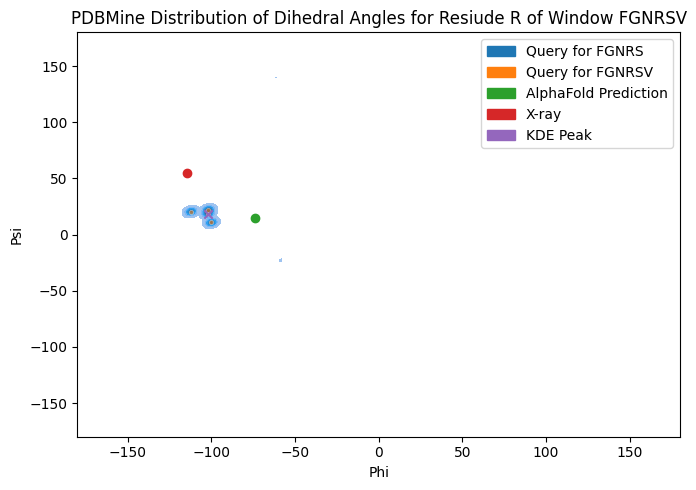

Max: P(-101.78272980501393, 20.557103064066837)=0.014908149981597951


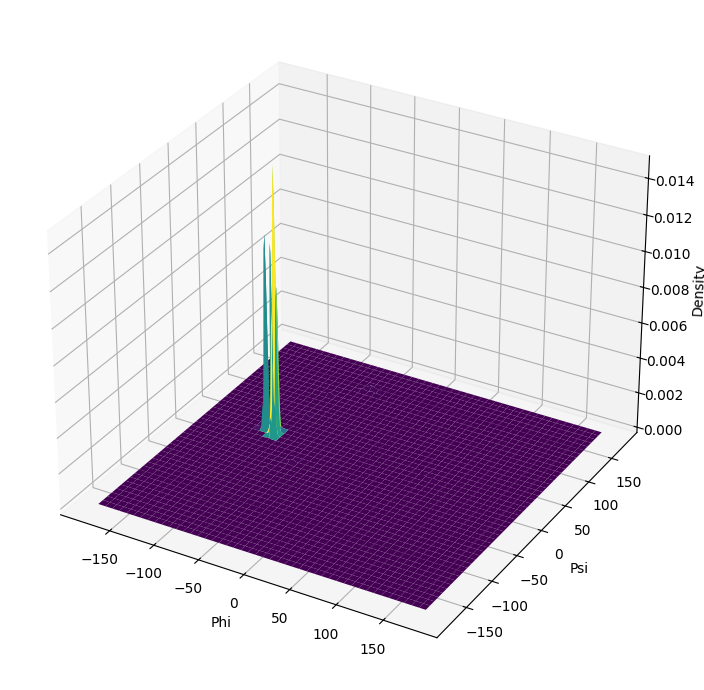

In [190]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

kdews = [1,128]
def plot_one_dist(seq, pred_id, pred_name=None, axlims=None, bw_method=None):
    pred_name = pred_name or pred_id
    inner_seq = get_subseq(seq)
    # inner_seq = seq[WINDOW_SIZE_CONTEXT // 2 - WINDOW_SIZE // 2:WINDOW_SIZE_CONTEXT // 2 + WINDOW_SIZE // 2 + 1]
    phi_psi_dist = phi_psi_mined[phi_psi_mined.seq == inner_seq].copy()
    phi_psi_ctxt_dist = phi_psi_mined_ctxt[phi_psi_mined_ctxt.seq == seq].copy()
    phi_psi_alpha = phi_psi_predictions[(phi_psi_predictions.protein_id == pred_id) & (phi_psi_predictions.seq_ctxt == seq)]
    xray_phi_psi_seq = xray_phi_psi[xray_phi_psi.seq_ctxt == seq]

    phi_psi_dist['weight'] = kdews[0]
    phi_psi_ctxt_dist['weight'] = kdews[1]
    phi_psi_dist = pd.concat([phi_psi_dist, phi_psi_ctxt_dist])
    print(phi_psi_dist.groupby('weight').count().iloc[:,0].values)

    fig, ax = plt.subplots(figsize=(7,5))
    # sns.jointplot(data=phi_psi_dist, x='phi', y='psi', kind='kde')
    sns.scatterplot(data=phi_psi_ctxt_dist, x='phi', y='psi', ax=ax, color=colors[1],zorder=5, alpha=0.5, marker='.')
    sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', weights='weight', ax=ax, fill=True, color=colors[0], bw_method=bw_method)

    kernel = gaussian_kde(phi_psi_dist[['phi','psi']].T, weights=phi_psi_dist['weight'], bw_method=bw_method)
    most_likely = phi_psi_dist.iloc[kernel(phi_psi_dist[['phi', 'psi']].values.T).argmax()]
    
    ax.plot(phi_psi_alpha.phi, phi_psi_alpha.psi, 'o', color=colors[2], label='AlphaFold Prediction', zorder=10)
    ax.plot(xray_phi_psi_seq.phi, xray_phi_psi_seq.psi, 'o', color=colors[3], label='X-ray', zorder=10)
    ax.scatter(most_likely.phi, most_likely.psi, color=colors[4], marker='x', label='KDE Peak', zorder=20)

    ax.legend(handles=[
        mpatches.Patch(color=colors[0], label=f'Query for {inner_seq}'),
        mpatches.Patch(color=colors[1], label=f'Query for {seq}'),
        mpatches.Patch(color=colors[2], label='AlphaFold Prediction'),
        mpatches.Patch(color=colors[3], label='X-ray'),
        mpatches.Patch(color=colors[4], label='KDE Peak')
    ])
    ax.set_title(f'PDBMine Distribution of Dihedral Angles for Resiude {seq[WINDOW_SIZE_CONTEXT//2]} of Window {seq}')

    ax.set_xlabel('Phi')
    ax.set_ylabel('Psi')

    if axlims:
        ax.set_xlim(axlims[0][0], axlims[0][1])
        ax.set_ylim(axlims[1][0], axlims[1][1])

    plt.tight_layout()
    plt.show()

def plot_one_dist_3d(seq, pred_id, pred_name=None, bw_method=None):
    inner_seq = get_subseq(seq)#seq[WINDOW_SIZE_CONTEXT // 2 - WINDOW_SIZE // 2:WINDOW_SIZE_CONTEXT // 2 + WINDOW_SIZE // 2 + 1]
    pred_name = pred_name or pred_id
    phi_psi_dist = phi_psi_mined[phi_psi_mined.seq == inner_seq].copy()
    phi_psi_ctxt_dist = phi_psi_mined_ctxt[phi_psi_mined_ctxt.seq == seq].copy()

    phi_psi_dist['weight'] = kdews[0]
    phi_psi_ctxt_dist['weight'] = kdews[1]
    phi_psi_dist = pd.concat([phi_psi_dist, phi_psi_ctxt_dist])

    x = phi_psi_dist[['phi','psi']].values.T
    weights = phi_psi_dist['weight'].values
    kde = gaussian_kde(x, weights=weights, bw_method=bw_method)

    x_grid, y_grid = np.meshgrid(np.linspace(-180, 180, 360), np.linspace(-180, 180, 360))
    grid = np.vstack([x_grid.ravel(), y_grid.ravel()])
    z = kde(grid).reshape(x_grid.shape)
    print(f'Max: P({grid[0,z.argmax()]}, {grid[1,z.argmax()]})={z.max()}')

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x_grid, y_grid, z, cmap='viridis')
    ax.set_xlabel('Phi')
    ax.set_ylabel('Psi')
    ax.set_zlabel('Density')
    plt.tight_layout()
    plt.show()

seq = overlapping_seqs[9]
bw_method = 0.1
plot_one_dist(seq, alphafold_id, 'AlphaFold', axlims=((-180, 180), (-180, 180)), bw_method=bw_method)
plot_one_dist_3d(seq, alphafold_id, 'AlphaFold', bw_method=bw_method)

In [450]:
def find_phi_psi_c(phi_psi_dist, phi_psi_ctxt_dist, eps, bw_method, kdews):
    
    # combine with weights
    phi_psi_dist['weight'] = kdews[0]
    phi_psi_ctxt_dist['weight'] = kdews[1]
    phi_psi_dist = pd.concat([phi_psi_dist, phi_psi_ctxt_dist])

    # Cluster with DBSCAN
    clustering = DBSCAN(eps=eps, min_samples=3).fit(phi_psi_dist.values)
    phi_psi_dist['cluster'] = clustering.labels_

    # Find most probable cluster
    kernel = gaussian_kde(phi_psi_dist[['phi','psi']].T, weights=phi_psi_dist['weight'], bw_method=bw_method)
    most_likely = phi_psi_dist.iloc[kernel(phi_psi_dist[['phi', 'psi']].values.T).argmax()]
    phi_psi_dist['prob'] = kernel(phi_psi_dist[['phi', 'psi']].values.T)
    c = phi_psi_dist[phi_psi_dist.cluster != -1].groupby('cluster').sum(numeric_only=True)
    if c.shape[0] == 0:
        print('No clusters found, using entire dist')
        phi_psi_dist_c = phi_psi_dist
    else:
        phi_psi_dist_c = phi_psi_dist[phi_psi_dist.cluster == c.prob.idxmax()]
    print('Chosen dist:', phi_psi_dist_c.shape, phi_psi_dist_c.phi.mean(), phi_psi_dist_c.psi.mean())
    return phi_psi_dist, phi_psi_dist_c, most_likely


def calc_maha_for_one(phi_psi: np.ndarray, phi_psi_dist: np.ndarray, kdepeak):    
    cov = np.cov(phi_psi_dist.T)
    if np.diag(cov).min() < 1:
        print('No significant variance in distribution - using distance to kde peak')
        return np.sqrt((phi_psi[0] - kdepeak[0])**2 + (phi_psi[1] - kdepeak[1])**2)
    
    icov = np.linalg.inv(cov)
    mean = phi_psi_dist.mean(axis=0)
    
    return np.sqrt((phi_psi - mean) @ icov @ (phi_psi - mean).T)

def calc_maha(phi_psi_preds, phi_psi_dist, kdepeak):
    cov = np.cov(phi_psi_dist.T)
    if np.diag(cov).min() < 1:
        print('No significant variance in distribution - using distance to kde peak')
        return np.sqrt(((phi_psi_preds[:,0] - kdepeak[0])**2) + ((phi_psi_preds[:,1] - kdepeak[1])**2))
    
    icov = np.linalg.inv(cov)
    diff = phi_psi_preds - phi_psi_dist.mean(axis=0)
    return np.sqrt((np.expand_dims((diff), 1) @ icov @ np.expand_dims((diff), 2)).squeeze())

Chosen dist: (36, 5) -125.74722222222223 128.30277777777778
{0: 66, 2: 36, 1: 15, 3: 6}


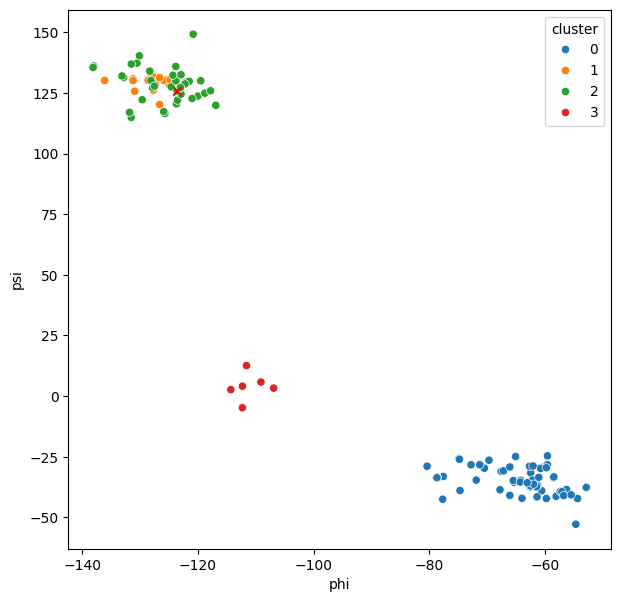

In [31]:
eps = 25
bw_method = None
seq = overlapping_seqs[2]
inner_seq = get_subseq(seq)
phi_psi_dist = phi_psi_mined.loc[phi_psi_mined.seq == inner_seq][['phi','psi']].copy()
phi_psi_ctxt_dist = phi_psi_mined_ctxt.loc[phi_psi_mined_ctxt.seq == seq][['phi','psi']].copy()
phi_psi_dist, phi_psi_dist_c, most_likely = find_phi_psi_c(phi_psi_dist, phi_psi_ctxt_dist, eps, bw_method, kdews)
value_counts = phi_psi_dist.cluster.value_counts().sort_values(ascending=False)
print(value_counts.to_dict())
fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(data=phi_psi_dist, x='phi', y='psi', hue='cluster', palette='tab10')
ax.scatter(most_likely.phi, most_likely.psi, marker='x', color='r')

In [378]:
phi_psi_predictions[phi_psi_predictions.seq_ctxt == seq]

,pos,seq,seq_ctxt,res,phi,psi,chain,protein_id,maha
90,93,KSQVD,KSQVDE,Q,-62.206175,NaN,A,T1030TS392_3,NaN
357,93,KSQVD,KSQVDE,Q,-67.343640,NaN,A,T1030TS367_1,NaN
624,93,KSQVD,KSQVDE,Q,-64.830329,-38.296329,A,T1030TS304_2,3.619460
891,93,KSQVD,KSQVDE,Q,-65.027830,-39.847195,A,T1030TS129_4,3.356209
1158,93,KSQVD,KSQVDE,Q,-66.081801,-41.883375,A,T1030TS257_1,2.898656
...,...,...,...,...,...,...,...,...,...
123244,93,KSQVD,KSQVDE,Q,-61.513450,-42.189864,A,T1030TS334_4,5.356530
123511,93,KSQVD,KSQVDE,Q,-64.363152,-41.932842,A,T1030TS473_4,3.659880
123778,93,KSQVD,KSQVDE,Q,-60.682963,-41.270601,A,T1030TS015_1,6.091254
124045,93,KSQVD,KSQVDE,Q,-63.684232,-46.159359,A,T1030TS288_1,4.383377


DQKDI (22, 2)
DQKDIL (0, 2)
Chosen dist: (12, 5) 60.87499999999999 20.724999999999998
[60.9 20.7]
No significant variance in distribution - using distance to kde peak
[60.9 20.7]
No significant variance in distribution - using distance to kde peak
No significant variance in distribution - using distance to kde peak
xray: 135.84066902771758
alpha: 139.62932796591969
preds:
                 0
count  421.000000
mean   144.092673
std     25.599794
min     16.263700
25%    138.225012
50%    139.777942
75%    141.693429
max    305.796892
{1: 12, 0: 8, -1: 2}


/tmp/ipykernel_3173062/2041332658.py:37: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=phi_psi_dist_c, x='phi', y='psi', ax=ax, legend=False, fill=True)


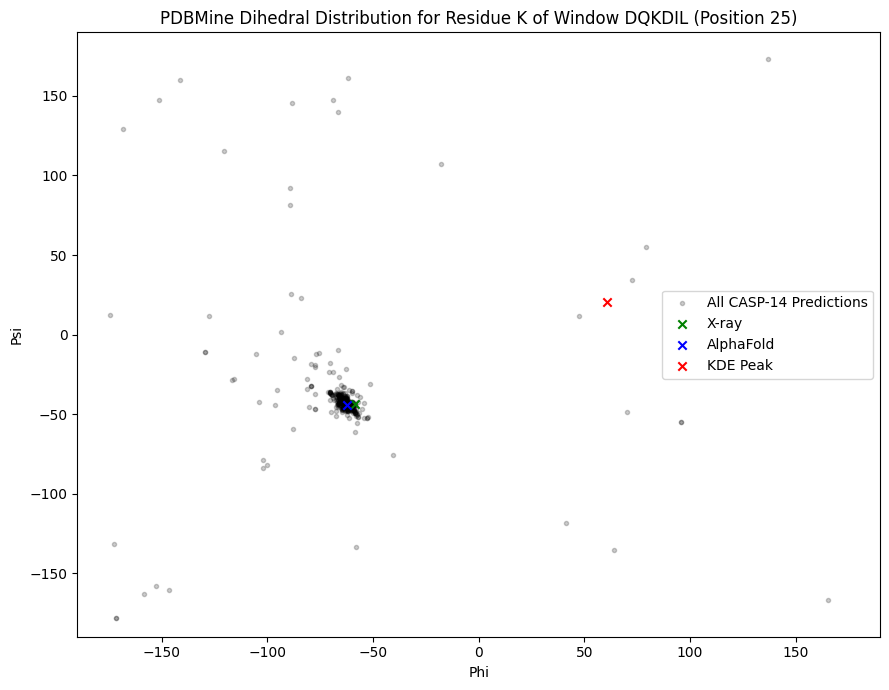

In [434]:
# For one window
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.neighbors import NearestNeighbors



def plot_clusters_for_window(seq, pred_id, pred_name=None, eps=10, bw_method=0.1, kdews=None, axlims=None, zoom=False, zoom_lims=None):
    inner_seq = get_subseq(seq)
    kdews = kdews or [1,128]
    pred_name = pred_name or pred_id
    phi_psi_dist = phi_psi_mined.loc[phi_psi_mined.seq == inner_seq][['phi','psi']].copy()
    phi_psi_ctxt_dist = phi_psi_mined_ctxt.loc[phi_psi_mined_ctxt.seq == seq][['phi','psi']].copy()
    xray = xray_phi_psi[xray_phi_psi.seq_ctxt == seq]
    alpha = phi_psi_predictions[(phi_psi_predictions.protein_id == pred_id) & (phi_psi_predictions.seq_ctxt == seq)]
    preds = phi_psi_predictions[phi_psi_predictions.seq_ctxt == seq]

    pos = xray['pos'].values[0]

    print(inner_seq, phi_psi_dist.shape)
    print(seq, phi_psi_ctxt_dist.shape)

    phi_psi_dist, phi_psi_dist_c, most_likely = find_phi_psi_c(phi_psi_dist, phi_psi_ctxt_dist, eps, bw_method, kdews)

    # Mahalanobis distance to most common cluster
    md_xray = calc_maha_for_one(xray[['phi','psi']].values[0], phi_psi_dist_c[['phi','psi']].values, most_likely[['phi', 'psi']].values, 'X-ray')
    md_alpha = calc_maha_for_one(alpha[['phi','psi']].values[0], phi_psi_dist_c[['phi','psi']].values, most_likely[['phi', 'psi']].values, pred_name)
    md_preds = calc_maha(preds[['phi','psi']].values, phi_psi_dist_c[['phi','psi']].values, most_likely[['phi', 'psi']].values)

    print('xray:', md_xray)
    print('alpha:', md_alpha)
    print('preds:\n', pd.DataFrame(md_preds).describe())
    value_counts = phi_psi_dist.cluster.value_counts().sort_values(ascending=False)
    print(value_counts.to_dict())

    fig, ax = plt.subplots(figsize=(9,7))
    sns.kdeplot(data=phi_psi_dist_c, x='phi', y='psi', ax=ax, legend=False, fill=True)
    # ax.scatter(phi_psi_ctxt_dist.phi, phi_psi_ctxt_dist.psi, color='orange', marker='.', label=f'{seq} Query')
    ax.scatter(preds.phi, preds.psi, color='black', marker='.', alpha=0.2, label='All CASP-14 Predictions')
    ax.scatter(xray.phi, xray.psi, color='green', marker='x', label='X-ray')
    ax.scatter(alpha.phi, alpha.psi, color='blue', marker='x', label=pred_name)
    ax.scatter(most_likely.phi, most_likely.psi, color='red', marker='x', label='KDE Peak')

    ax.set_xlabel('Phi')
    ax.set_ylabel('Psi')
    res = phi_psi_predictions.loc[phi_psi_predictions.seq==inner_seq, 'res'].values[0]
    ax.set_title(f'PDBMine Dihedral Distribution for Residue {res} of Window {seq} (Position {pos})')
    ax.legend()
    if axlims:
        ax.set_xlim(axlims[0][0], axlims[0][1])
        ax.set_ylim(axlims[1][0], axlims[1][1])
    plt.tight_layout()
    plt.show()
seq = overlapping_seqs[0]
seq = 'DQKDIL'
plot_clusters_for_window(seq, alphafold_id, 'AlphaFold', eps=25, bw_method=None, axlims=((-190, 190), (-190, 190)))

In [451]:
def get_md_for_all_predictions(eps=10, bw_method=None, kdews=None):
    kdews = kdews or [1,128]
    phi_psi_predictions['md'] = np.nan
    xray_phi_psi['md'] = np.nan
    for i,seq in enumerate(phi_psi_predictions.seq_ctxt.unique()):
        inner_seq = get_subseq(seq)
        phi_psi_dist = phi_psi_mined.loc[phi_psi_mined.seq == inner_seq][['phi','psi']]
        phi_psi_ctxt_dist = phi_psi_mined_ctxt.loc[phi_psi_mined_ctxt.seq == seq][['phi','psi']]
        print(f'{seq}: {phi_psi_dist.shape[0]} {phi_psi_ctxt_dist.shape[0]}')

        if phi_psi_ctxt_dist.shape[0] > 2:
            print('Enough context data for KDE - Using Full Context')
        if phi_psi_dist.shape[0] <= 2:
            print(f'Skipping {seq} - not enough data points')
            # leave as nan
            continue

        phi_psi_dist, phi_psi_dist_c, most_likely = find_phi_psi_c(phi_psi_dist, phi_psi_ctxt_dist, eps, bw_method, kdews)

        # Mahalanobis distance to most common cluster
        xray = xray_phi_psi[xray_phi_psi.seq_ctxt == seq][['phi','psi']]
        if xray.shape[0] == 0:
            print(f'No xray seq {seq}')
        else:
            md_xray = calc_maha_for_one(xray[['phi','psi']].values[0], phi_psi_dist_c[['phi','psi']].values, most_likely[['phi', 'psi']].values)
            xray_phi_psi.loc[xray_phi_psi.seq_ctxt == seq, 'md'] = md_xray
            
        preds = phi_psi_predictions.loc[phi_psi_predictions.seq_ctxt == seq][['phi','psi']]
        if preds.shape[0] == 0:
            print(f'No predictions seq {seq}')
        else:
            md = calc_maha(preds[['phi','psi']].values, phi_psi_dist_c[['phi','psi']].values, most_likely[['phi', 'psi']].values)
            phi_psi_predictions.loc[phi_psi_predictions.seq_ctxt == seq, 'md'] = md
        print(xray.shape, preds.shape, phi_psi_dist.shape, phi_psi_ctxt_dist.shape)

    phi_psi_predictions.to_csv(outdir / f'phi_psi_predictions_md-eps{eps}.csv', index=False)
    xray_phi_psi.to_csv(outdir / f'xray_phi_psi_md-eps{eps}.csv', index=False)
        
eps=5
bw_method=None
kdews=[1,128]
get_md_for_all_predictions(eps, bw_method, kdews)

QELGKQ: 253 0
Chosen dist: (84, 5) -88.48452380952382 3.766666666666667
(1, 2) (462, 2) (253, 5) (0, 3)
ELGKQS: 258 3
Enough context data for KDE - Using Full Context
Chosen dist: (135, 5) -59.53407407407406 -40.068148148148154
(1, 2) (462, 2) (261, 5) (3, 3)
LGKQSR: 56 0
Chosen dist: (20, 5) -71.365 -18.405
(1, 2) (462, 2) (56, 5) (0, 3)
GKQSRR: 11 0
No clusters found, using entire dist
Chosen dist: (11, 5) -70.93636363636364 128.66363636363636
(1, 2) (467, 2) (11, 5) (0, 3)
KQSRRS: 47 0
Chosen dist: (35, 5) -69.81714285714287 -40.19142857142858
(1, 2) (467, 2) (47, 5) (0, 3)
QSRRSQ: 132 0
Chosen dist: (53, 5) -62.733962264150954 -34.869811320754714
(1, 2) (468, 2) (132, 5) (0, 3)
SRRSQD: 20 0
Chosen dist: (12, 5) -144.28333333333333 115.09166666666664
No significant variance in distribution - using distance to kde peak
No significant variance in distribution - using distance to kde peak
(1, 2) (469, 2) (20, 5) (0, 3)
RRSQDI: 6 0
No clusters found, using entire dist
Chosen dist: (6, 5

Chosen dist: (7, 5) -73.38571428571427 -25.12857142857143
(1, 2) (469, 2) (43, 5) (1, 3)
SQDIIK: 271 22
Enough context data for KDE - Using Full Context
Chosen dist: (16, 5) -113.8125 11.975
(1, 2) (469, 2) (293, 5) (22, 3)
QDIIKS: 296 3
Enough context data for KDE - Using Full Context
Chosen dist: (256, 5) -58.241406250000004 -44.665234375000004
(1, 2) (469, 2) (299, 5) (3, 3)
DIIKSL: 226 14
Enough context data for KDE - Using Full Context
Chosen dist: (182, 5) -63.59065934065934 -40.42032967032967
(1, 2) (469, 2) (240, 5) (14, 3)
IIKSLG: 166 0
Chosen dist: (136, 5) -62.483088235294126 -38.932352941176475
(1, 2) (469, 2) (166, 5) (0, 3)
IKSLGF: 189 31
Enough context data for KDE - Using Full Context
Chosen dist: (30, 5) -88.21333333333332 2.83
(1, 2) (469, 2) (220, 5) (31, 3)
KSLGFL: 160 14
Enough context data for KDE - Using Full Context
Chosen dist: (128, 5) -85.01953125 -4.7328125
(1, 2) (469, 2) (174, 5) (14, 3)
SLGFLS: 222 21
Enough context data for KDE - Using Full Context
Chose

/tmp/ipykernel_3173062/2992430676.py:35: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((phi_psi - mean) @ icov @ (phi_psi - mean).T)
/tmp/ipykernel_3173062/2992430676.py:45: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((np.expand_dims((diff), 1) @ icov @ np.expand_dims((diff), 2)).squeeze())


Chosen dist: (129, 5) 74.0984496124031 8.453488372093023
(1, 2) (463, 2) (204, 5) (0, 3)
EGKLNI: 70 4
Enough context data for KDE - Using Full Context
Chosen dist: (4, 5) -93.325 162.7
(1, 2) (463, 2) (74, 5) (4, 3)
GKLNIT: 468 1
Chosen dist: (330, 5) -82.92969696969696 140.64181818181817
(1, 2) (463, 2) (469, 5) (1, 3)
KLNITA: 115 13
Enough context data for KDE - Using Full Context
Chosen dist: (10, 5) -109.66000000000001 142.06
No significant variance in distribution - using distance to kde peak
No significant variance in distribution - using distance to kde peak
(1, 2) (463, 2) (128, 5) (13, 3)
LNITAA: 185 87
Enough context data for KDE - Using Full Context
Chosen dist: (20, 5) -52.93499999999999 131.57999999999998
(1, 2) (463, 2) (272, 5) (87, 3)
NITAAM: 436 0
Chosen dist: (169, 5) -146.59230769230768 150.53550295857988
No xray seq NITAAM
(0, 2) (463, 2) (436, 5) (0, 3)
ITAAMN: 22 0
Chosen dist: (5, 5) -76.72 -40.440000000000005
No xray seq ITAAMN
No significant variance in distrib

In [452]:
eps=5
phi_psi_predictions = pd.read_csv(outdir / f'phi_psi_predictions_md-eps{eps}.csv')
xray_phi_psi = pd.read_csv(outdir / f'xray_phi_psi_md-eps{eps}.csv')

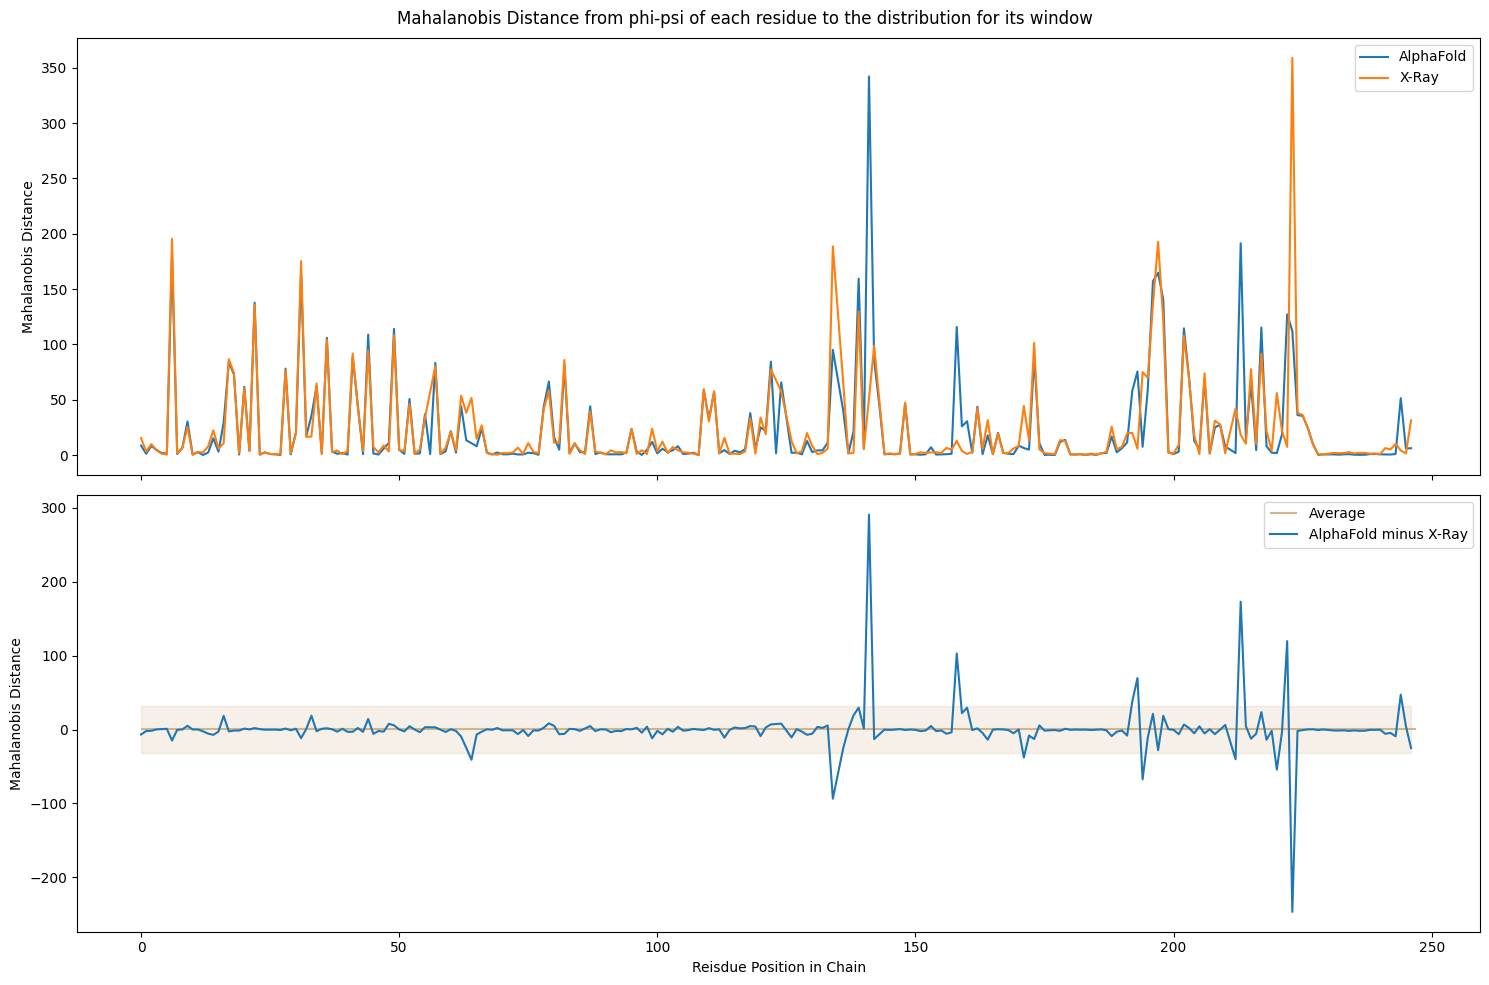

In [465]:
# Plot xray vs prediction md for each residue of one prediction
def plot_res_vs_md(pred_id, pred_name=None, highlight_res=None, limit_quantile=None):
    pred_name = pred_name or pred_id
    phi_psi_predictions['Source'] = 'CASP Prediction'
    phi_psi_predictions.loc[phi_psi_predictions.protein_id == pred_id, 'Source'] = pred_name
    alpha = phi_psi_predictions.loc[phi_psi_predictions.protein_id == pred_id]
    xray_phi_psi['Source'] = 'X-Ray'
    both = pd.merge(alpha, xray_phi_psi[['seq', 'md']], how='inner', on=['seq','seq'], suffixes=('_alpha','_xray'))
    both['md_diff'] = both['md_alpha'] - both['md_xray']
    fig, axes = plt.subplots(2, figsize=(15,10), sharex=True)
    both_limit = both.copy()
    if limit_quantile:
        both_limit[both_limit.md_alpha > both_limit.md_alpha.quantile(limit_quantile)] = np.nan
        both_limit[both_limit.md_xray > both_limit.md_xray.quantile(limit_quantile)] = np.nan
        both_limit[both_limit.md_diff > both_limit.md_diff.quantile(limit_quantile)] = np.nan
    sns.lineplot(data=both_limit.reset_index(), x='index', y='md_alpha', ax=axes[0], label=pred_name)
    sns.lineplot(data=both_limit.reset_index(), x='index', y='md_xray', ax=axes[0], label='X-Ray')
    axes[0].set_ylabel('Mahalanobis Distance')
    axes[1].hlines(both_limit['md_diff'].mean(), xmin=0, xmax=len(both_limit), color='tan', label='Average')
    axes[1].fill_between(x=both_limit.index, y1=both_limit['md_diff'].mean() + both_limit['md_diff'].std(), y2=both_limit['md_diff'].mean() - both_limit['md_diff'].std(), color='tan', alpha=0.2)
    sns.lineplot(data=both_limit.reset_index(), x='index', y='md_diff', ax=axes[1], label=f'{pred_name} minus X-Ray')
    axes[1].set_ylabel('Mahalanobis Distance')
    axes[1].set_xlabel('Reisdue Position in Chain')
    fig.suptitle('Mahalanobis Distance from phi-psi of each residue to the distribution for its window')
    plt.tight_layout()

    if highlight_res:
        for ax in axes:
            ax.axvspan(highlight_res[0], highlight_res[1], color='red', alpha=0.2)
    
    return both

protein_ids = phi_psi_predictions.protein_id.unique()
both = plot_res_vs_md(protein_ids[3], pred_name="AlphaFold")
# NOTE: for presentation, highlight area around res-300 to show this is where alphafold did bad

R-squared: 0.329688


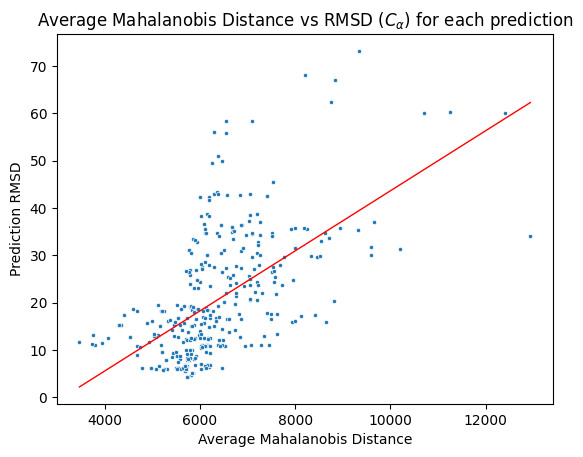

In [470]:
# Compare rmsd and mahalanobis distance
import matplotlib.pyplot as plt
from scipy.stats import linregress

def filter_and_agg(series, agg='sum', quantile=0.8):
    series = series[series < series.quantile(quantile)]
    return series.agg(agg)

def calc_perc_na(series):
    return series.sum() / len(series)

def plot_md_vs_rmsd(rmsd_lim=np.inf, md_lim_low=0, md_lim=np.inf):
    phi_psi_predictions['md_na'] = phi_psi_predictions.md.isna()
    group_maha = phi_psi_predictions.groupby('protein_id', as_index=False).agg(
        md=('md',lambda x: filter_and_agg(x, agg='sum', quantile=1)), 
        std_md=('md',lambda x: filter_and_agg(x, agg='std', quantile=0.8)), 
        md_na=('md_na',calc_perc_na)
    )
    # group_maha = phi_psi_predictions.groupby('protein_id', as_index=False).agg({'md': filter_and_agg, 'md_na':calc_perc_na})
    group_maha = group_maha.merge(results[['Model', 'RMS_CA']], left_on='protein_id', right_on='Model', how='inner')
    group_maha = group_maha[group_maha.md_na <= group_maha.md_na.quantile(.9)]
    group_maha = group_maha[(group_maha.RMS_CA < rmsd_lim) & (group_maha.md > md_lim_low) & (group_maha.md < md_lim)].dropna()

    fig, ax = plt.subplots()
    sns.scatterplot(data=group_maha, x='md', y='RMS_CA', ax=ax, marker='.', legend=False)
    sns.regplot(data=group_maha, x='md', y='RMS_CA', ax=ax, ci=False, scatter=False, color='red', line_kws={'lw':1}, label='Regression Line')
    ax.set_xlabel('Average Mahalanobis Distance')
    ax.set_ylabel('Prediction RMSD')
    ax.set_title(r'Average Mahalanobis Distance vs RMSD ($C_{\alpha}$) for each prediction')
    regr = linregress(group_maha.md, group_maha.RMS_CA)
    print(f"R-squared: {regr.rvalue**2:.6f}")
    return group_maha
group_maha = plot_md_vs_rmsd()
# ax.set_xlim((0.8,1.4))
# ax.set_ylim((0,6))

# Specific Cases

In [501]:
import plotly.express as px
fig = px.scatter(group_maha, x='md', y='RMS_CA', text='protein_id', hoverinfo='text')
fig.show(renderer='browser')

TypeError: scatter() got an unexpected keyword argument 'hoverinfo'

In [122]:
group_maha.std_md.describe()

count    458.000000
mean      12.986630
std        2.504925
min        6.878770
25%       11.216831
50%       12.169726
75%       14.113017
max       25.034741
Name: std_md, dtype: float64

In [74]:
group_maha.md_na.describe()

count    458.000000
mean       0.041672
std        0.092062
min        0.000000
25%        0.000000
50%        0.000000
75%        0.029740
max        0.646840
Name: md_na, dtype: float64

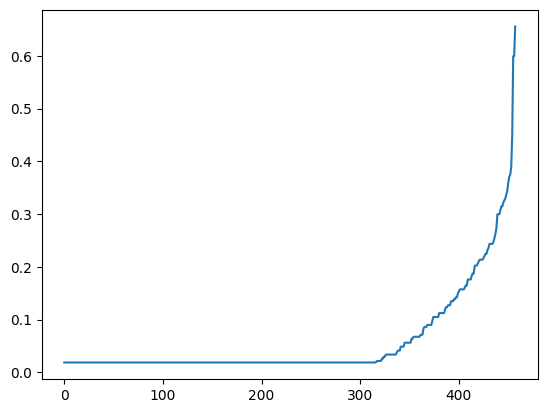

In [93]:
plt.plot(group_maha.md_na.sort_values().values)

R-squared: 0.247081


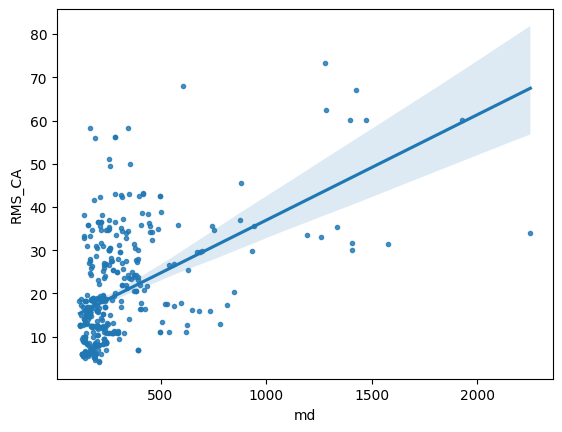

In [424]:
filtered = group_maha[group_maha.md_na <= group_maha.md_na.quantile(0.90)]
sns.regplot(data=filtered, x='md', y='RMS_CA', marker='.')
regr = linregress(filtered.md, filtered.RMS_CA)
print(f"R-squared: {regr.rvalue**2:.6f}")

In [464]:
# group_maha.sort_values('RMS_CA').iloc[::1].head(5)
# group_maha.sort_values('md').iloc[::-1].head(5)
# filtered.sort_values('md').iloc[::1].head(5)
filtered.sort_values('RMS_CA').iloc[::1].head(5)
filtered[(filtered.RMS_CA < 40) & (filtered.RMS_CA > 35)].sort_values('md')

,protein_id,md,md_na,Model,RMS_CA
266,T1030TS304_5,135.612656,0.000000,T1030TS304_5,38.254
264,T1030TS304_3,155.884131,0.000000,T1030TS304_3,35.877
428,T1030TS453_1,155.884131,0.000000,T1030TS453_1,35.877
246,T1030TS278_5,204.177549,0.000000,T1030TS278_5,36.440
337,T1030TS343_1,204.177549,0.000000,T1030TS343_1,36.440
294,T1030TS324_3,214.567795,0.000000,T1030TS324_3,35.548
168,T1030TS200_3,217.226457,0.000000,T1030TS200_3,36.634
52,T1030TS042_4,217.226457,0.000000,T1030TS042_4,36.634
328,T1030TS340_1,223.174508,0.000000,T1030TS340_1,38.211
129,T1030TS138_4,255.174223,0.000000,T1030TS138_4,35.356


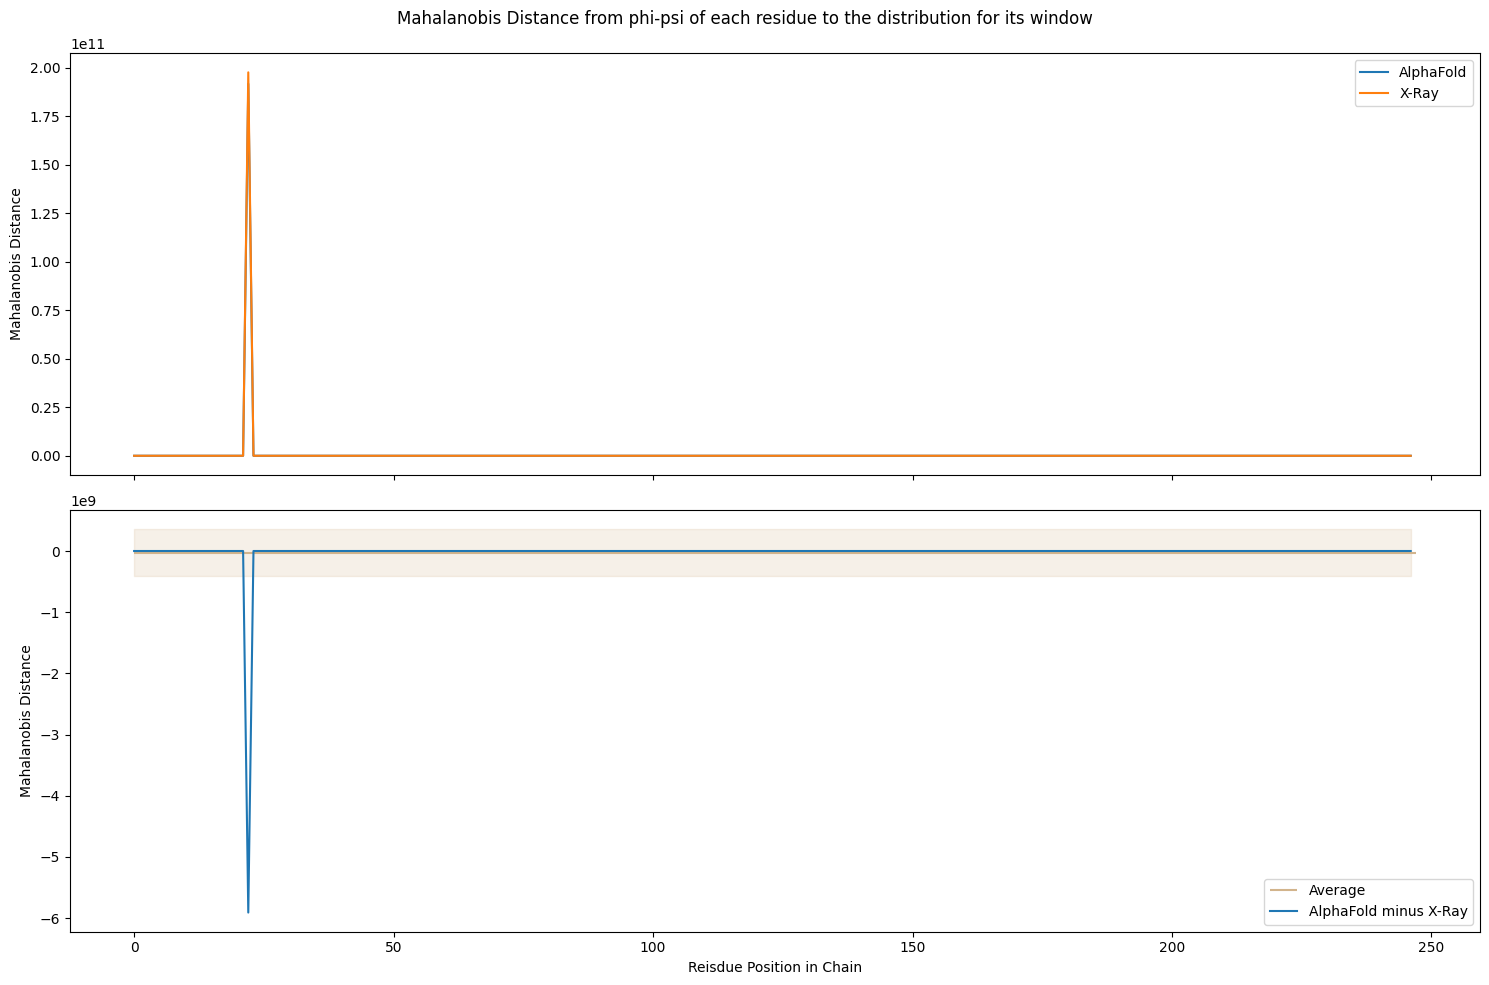

In [212]:
id = protein_ids[5]
both = plot_res_vs_md(id, pred_name="AlphaFold", limit_quantile=1)

In [213]:
both.sort_values('md_xray', ascending=False)

,pos,seq,seq_ctxt,res,phi,psi,chain,protein_id,md_alpha,md_na,Source,md_xray,md_diff
22,25,DQKDI,DQKDIL,K,-63.936121,-32.989649,A,T1030TS014_5,1.916906e+11,False,AlphaFold,1.975998e+11,-5.909165e+09
6,9,SRRSQ,SRRSQD,R,-57.369290,-50.319248,A,T1030TS014_5,6.483302e+03,False,AlphaFold,6.815804e+03,-3.325016e+02
134,147,VKQYN,VKQYNE,Q,-66.173021,-25.335273,A,T1030TS014_5,4.525206e+03,False,AlphaFold,4.718784e+03,-1.935789e+02
87,95,QVDEF,QVDEFV,D,-62.346070,-39.859461,A,T1030TS014_5,4.405687e+03,False,AlphaFold,4.469243e+03,-6.355596e+01
213,231,DKQTF,DKQTFG,Q,-58.373846,-23.549354,A,T1030TS014_5,8.145236e+03,False,AlphaFold,2.357360e+03,5.787876e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,141,TAIDN,TAIDNV,I,-55.875096,-53.289773,A,T1030TS014_5,NaN,True,AlphaFold,NaN,NaN
135,148,KQYNE,KQYNEG,Y,-53.576735,-30.146381,A,T1030TS014_5,NaN,True,AlphaFold,NaN,NaN
143,156,NITAA,NITAAM,T,-59.579769,-43.926492,A,T1030TS014_5,6.116111e+01,False,AlphaFold,NaN,NaN
211,229,FRDKQ,FRDKQT,D,-61.652907,-30.703902,A,T1030TS014_5,NaN,True,AlphaFold,NaN,NaN


[22]


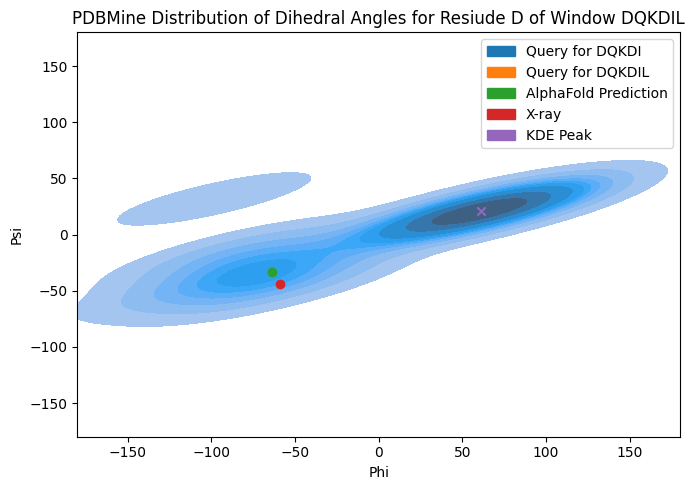

Max: P(60.66852367688023, 20.557103064066837)=0.0001933291437276712


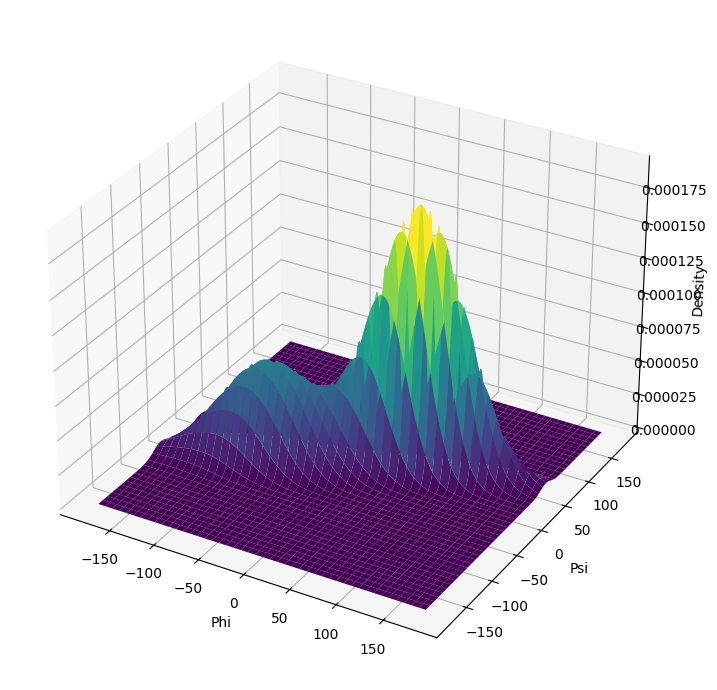

In [214]:
plot_one_dist(seq, id, axlims=((-180, 180), (-180, 180)), bw_method=None)
plot_one_dist_3d(seq, id, bw_method=None)

In [264]:
seq = 'DQKDIL'#both.sort_values('md_alpha', ascending=False).iloc[0].seq_ctxt_alpha
plot_clusters_for_window(seq, id, eps=15, bw_method=None, axlims=((-190, 190), (-190, 190)))

DQKDI (22, 2)
DQKDIL (0, 2)
Chosen dist: (12, 5) 60.87499999999999 20.724999999999998
No significant variance in distribution - using mean
[[-58.67658349 -43.75252549]]


AttributeError: 'numpy.ndarray' object has no attribute 'phi'

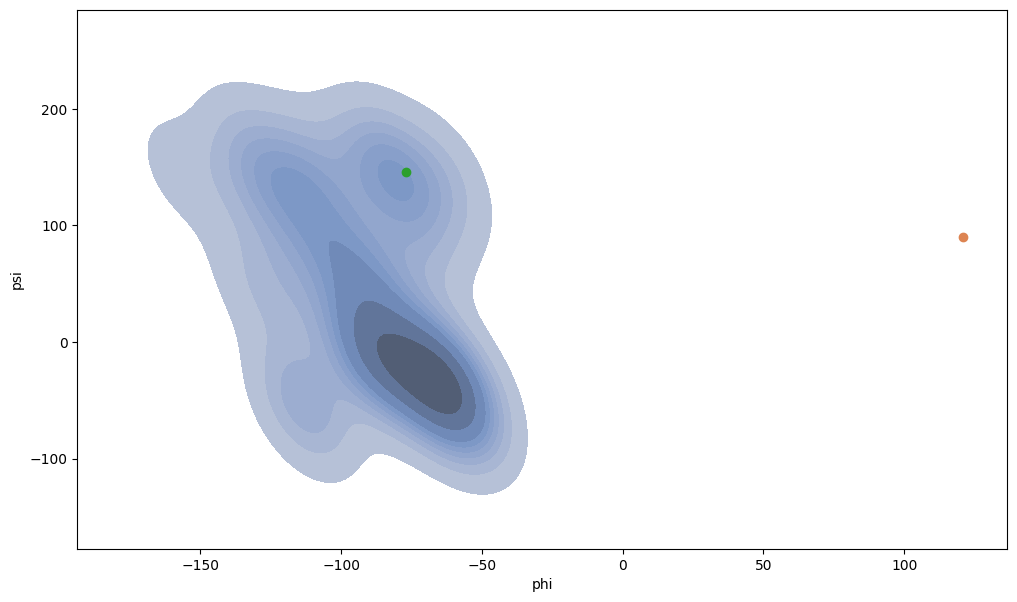

In [326]:
# plot dists with highest mahalanobis distance for alphafold
m = 0
fig, ax = plt.subplots(figsize=(12,7))
high = highest.iloc[0]
seq = high.seq_ctxt_alpha
xray_phi_psi_seq = xray_phi_psi[xray_phi_psi.seq_ctxt == seq]
phi_psi_alpha_seq = phi_psi_predictions[(phi_psi_predictions.protein_id==id) & (phi_psi_predictions.seq_ctxt == seq)]
phi_psi_dist = phi_psi_mined[phi_psi_mined.seq == get_subseq(seq)]

sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', ax=ax, fill=True, color='#7490c0', legend=True)
ax.plot(phi_psi_alpha_seq.phi, phi_psi_alpha_seq.psi, 'o', color='#dd8452', label='Prediction')
ax.plot(xray_phi_psi_seq.phi, xray_phi_psi_seq.psi, 'o', color='tab:green', label='X-ray')